# Evaluation Baseline/one dataset

In [352]:
# dependecies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [353]:
# Testing with Urdu
train_english = pd.read_csv(r'train_english_test_urdu_percentage.csv')
train_german = pd.read_csv(r'train_german_test_urdu_percentage.csv')
train_italian = pd.read_csv(r'train_italian_test_urdu_percentage.csv')

# Training with Urdu
test_english = pd.read_csv(r'train_urdu_test_english_percentage.csv')
test_german = pd.read_csv(r'train_urdu_test_german_percentage.csv')
test_italian = pd.read_csv(r'train_urdu_test_italian_percentage.csv')

In [354]:
# Melt the DataFrame to long format for easier plotting
train_english = train_english.melt(id_vars=["Model", "Percentage"], var_name="Metric", value_name="Score")
train_german = train_german.melt(id_vars=["Model", "Percentage"], var_name="Metric", value_name="Score")
train_italian = train_italian.melt(id_vars=["Model", "Percentage"], var_name="Metric", value_name="Score")

test_english = test_english.melt(id_vars=["Model", "Percentage"], var_name="Metric", value_name="Score")
test_german = test_german.melt(id_vars=["Model", "Percentage"], var_name="Metric", value_name="Score")
test_italian = test_italian.melt(id_vars=["Model", "Percentage"], var_name="Metric", value_name="Score")

In [355]:
# Define dataset names
train_urdu_names = ['English', 'German', 'Italian']
test_urdu_names = ['English', 'German', 'Italian']

# combine dataframes
train_urdu_dfs = [test_english, test_german, test_italian]
test_urdu_dfs = [train_english, train_german, train_italian]

train_urdu_dfs = pd.concat(
        [df.assign(Dataset=name) for df, name in zip(train_urdu_dfs, train_urdu_names)],
        ignore_index=True
    )
test_urdu_dfs = pd.concat(
        [df.assign(Dataset=name) for df, name in zip(test_urdu_dfs, test_urdu_names)],
        ignore_index=True
    )

In [356]:
def plot_percentage(model, percentage_dfs, datasets, metric, title):

    scores = [percentage_dfs[(percentage_dfs['Dataset'] == ds) & 
                             (percentage_dfs['Metric'] == metric) & 
                             (percentage_dfs['Model'] == model)]['Score'].values * 100 for ds in datasets]

    scores_df = pd.DataFrame(scores).T
    scores_df.columns = datasets
    scores_df = scores_df.set_index((scores_df.index + 1) * 10)

    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    sns.lineplot(data=scores_df)
    plt.title(f"{title} using {model}")
    plt.xlabel("Percentage of Test Data", fontsize = 12)
    plt.ylabel(f"{metric} (%)", fontsize = 12)
    plt.tight_layout()
    plt.show()

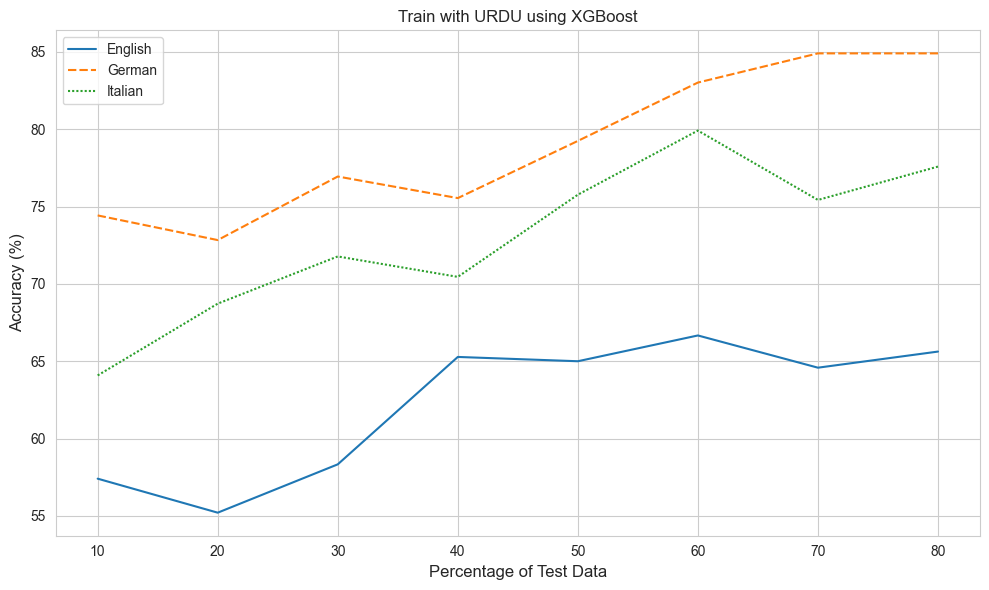

In [357]:
plot_percentage(model="XGBoost", percentage_dfs=train_urdu_dfs, datasets=train_urdu_names, metric="Accuracy", title=f"Train with URDU")

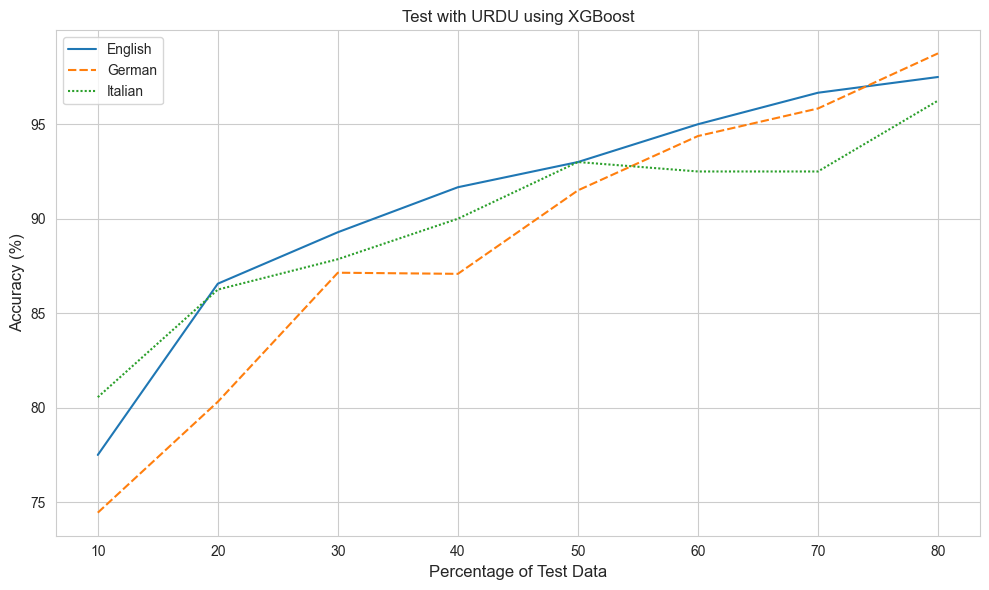

In [358]:
plot_percentage(model="XGBoost", percentage_dfs=test_urdu_dfs, datasets=test_urdu_names, metric="Accuracy", title="Test with URDU")